In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

In [2]:
project_dir_path = '/n/data1/hms/dbmi/farhat/Roger/gatesMRI/Projects/Biomarkers'

#### Load Packages

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
import matplotlib.pylab as pl
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import scipy.stats
import networkx as nx
import networkx.algorithms.community as nxcom
import community
from collections import Counter
import pickle
import seaborn as sns

#for exporting to Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

Create directory for figures

In [4]:
figures_dir_path = f'{project_dir_path}/Figures/Notebook 9/Drug Treatment GSE40553 cohort'
if not os.path.exists(figures_dir_path):
    os.makedirs(figures_dir_path)

Specify directory paths

In [5]:
#directoy for Pickled Objects
pickled_objects_dir = f'{project_dir_path}/Data/Pickled Files/'

#specify directory for Data
data_dir = f'{project_dir_path}/Data/'

#RNAseq Data
RNAseq_annotation_file = f'{data_dir}Drug Treatment RNAseq Expression/CSV files/GSE40553/GSE40553_TreatMonitoring_MultivariateModel_input Info.csv'
RNAseq_gene_exp_matrix_file = f'{data_dir}Drug Treatment RNAseq Expression/CSV files/GSE40553/GSE40553_TreatMonitoring_MultivariateModel_input Exp_EachGene.csv'

Set parameters for plotting

In [6]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=1.0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

## [1] Load Data

### [1.1] Weighted Degrees for Nodes (genes) & Mean $log_2(Fold Change)$ for Nodes (genes)

ATB v HC

In [7]:
weighted_deg_ATB_HC_series = pd.read_pickle(pickled_objects_dir + 'Network Files/weighted degree series/ATB_v_HC.pkl')
mean_logFC_ATB_HC_series = pd.read_pickle(pickled_objects_dir + 'Network Files/mean logFC network nodes series/ATB_v_HC.pkl')

ATB_HC_df = pd.DataFrame(index = mean_logFC_ATB_HC_series.index)
ATB_HC_df['mean_log2FC'] = mean_logFC_ATB_HC_series.values
ATB_HC_df['weighted_degree'] = weighted_deg_ATB_HC_series[mean_logFC_ATB_HC_series.index].values

ATB v LTBI

In [8]:
weighted_deg_ATB_LTBI_series = pd.read_pickle(pickled_objects_dir + 'Network Files/weighted degree series/ATB_v_LTBI.pkl')
mean_logFC_ATB_LTBI_series = pd.read_pickle(pickled_objects_dir + 'Network Files/mean logFC network nodes series/ATB_v_LTBI.pkl')

ATB_LTBI_df = pd.DataFrame(index = mean_logFC_ATB_LTBI_series.index)
ATB_LTBI_df['mean_log2FC'] = mean_logFC_ATB_LTBI_series.values
ATB_LTBI_df['weighted_degree'] = weighted_deg_ATB_LTBI_series[mean_logFC_ATB_LTBI_series.index].values

ATB v OD

In [9]:
weighted_deg_ATB_OD_series = pd.read_pickle(pickled_objects_dir + 'Network Files/weighted degree series/ATB_v_OD.pkl')
mean_logFC_ATB_OD_series = pd.read_pickle(pickled_objects_dir + 'Network Files/mean logFC network nodes series/ATB_v_OD.pkl')

ATB_OD_df = pd.DataFrame(index = mean_logFC_ATB_OD_series.index)
ATB_OD_df['mean_log2FC'] = mean_logFC_ATB_OD_series.values
ATB_OD_df['weighted_degree'] = weighted_deg_ATB_OD_series[mean_logFC_ATB_OD_series.index].values

### [1.2] Top weighted nodes in (1) ATB/HC & ATB/LTBI & ATB/OD networks $(n = 24)$ and (2) ATB/HC & ATB/LTBI networks $(n = 23)$

In [10]:
with open(f'{pickled_objects_dir}Network Files/top weighted node lists/ATB_HC_and_ATB_LTBI_and_ATB_OD.pkl', 'rb') as f:
    top_genes_ATB_HC_and_ATB_LTBI_and_ATB_OD = pickle.load(f)

In [11]:
len(top_genes_ATB_HC_and_ATB_LTBI_and_ATB_OD)

24

In [12]:
with open(f'{pickled_objects_dir}Network Files/top weighted node lists/ATB_HC_and_ATB_LTBI.pkl', 'rb') as f:
    top_genes_ATB_HC_and_ATB_LTBI = pickle.load(f)

In [13]:
len(top_genes_ATB_HC_and_ATB_LTBI)

23

Combine genes into a *single gene set*

In [14]:
gene_sig_set = top_genes_ATB_HC_and_ATB_LTBI_and_ATB_OD + top_genes_ATB_HC_and_ATB_LTBI

In [15]:
len(gene_sig_set)

47

Split between genes that are **upregulated** and those that are **downregulated**

Genes in signature set are all in ATB/HC & ATB/LTBI networks

In [16]:
gene_sig_set_up = []
gene_sig_set_down = []

for gene_i in gene_sig_set:
    
    if (ATB_HC_df.mean_log2FC[gene_i] > 0) and (ATB_LTBI_df.mean_log2FC[gene_i] > 0):
        
        gene_sig_set_up.append(gene_i)
        
    elif (ATB_HC_df.mean_log2FC[gene_i] < 0) and (ATB_LTBI_df.mean_log2FC[gene_i] < 0):
        
        gene_sig_set_down.append(gene_i)

In [17]:
len(gene_sig_set_up)

36

In [18]:
len(gene_sig_set_down)

11

### [1.3] Drug Treatment data from Wen-Han

In [19]:
gene_exp_info_df = pd.read_csv(RNAseq_annotation_file).set_index('Unnamed: 0')
gene_exp_info_df.index.rename('GSM_ID', inplace = True)

In [20]:
gene_exp_info_df.head()

,title,geographical location,status,time,disease,ID,group,groupName
GSM_ID,,,,,,,,
GSM996408,active TB pre-treatment [401/0],South Africa patient blood,active TB pre-treatment,0,PTB,401,1,0d prior to treatment
GSM996330,active TB 12 months post treatment [401/12],South Africa patient blood,active TB 12 months post treatment,360,PTB,401,7,360d after treatment
GSM996398,active TB pre-treatment [402/0],South Africa patient blood,active TB pre-treatment,0,PTB,402,1,0d prior to treatment
GSM996365,active TB 6 months post treatment [402/06],South Africa patient blood,active TB 6 months post treatment,180,PTB,402,6,180d after treatment
GSM996453,active TB 12 months post treatment [402/12],South Africa patient blood,active TB 12 months post treatment,360,PTB,402,7,360d after treatment


In [21]:
np.shape(gene_exp_info_df)

(131, 8)

In [22]:
gene_exp_matrix_df = pd.read_csv(RNAseq_gene_exp_matrix_file).set_index('Unnamed: 0')
gene_exp_matrix_df.index.rename('GSM_ID', inplace = True)
gene_exp_matrix_df = gene_exp_matrix_df.T

In [23]:
gene_exp_matrix_df.head()

GSM_ID,EEF1A1,GAPDH,LOC643334,SLC35E2,DUSP22,LOC642820,RPS28,IPO13,TESSP1,LOC653113,...,hematopoietic_progenitor,macrophage_m0,macrophage_m1,macrophage_m2,memory_B_cell,myeloid_dendritic_cell,naive_B_cell,neutrophil,plasma_cell,plasmacytoid_dendritic_cell
GSM996408,-0.262689,0.496376,0.306659,-0.281313,-0.882281,0.654244,-0.374078,-0.120265,-0.176062,0.205200,...,0.165424,0.031117,0.159177,0.000000,0.086135,0.0,0.000000,0.231802,0.096727,0.000000
GSM996330,-0.045556,0.015934,-0.369687,2.731641,1.562389,0.739739,-0.305610,0.278352,1.954948,0.342200,...,0.000000,0.000000,0.043323,0.000000,0.319639,0.0,0.000000,0.000000,0.021595,0.190413
GSM996398,0.153195,-0.086382,0.334537,1.816955,-0.854403,-0.548657,0.029551,0.455776,-0.148183,1.494945,...,0.000000,0.000000,0.284942,0.000000,0.388739,0.0,0.000000,0.000000,0.000000,0.000000
GSM996365,-0.416633,-0.761357,-0.654867,-1.242839,0.156193,-0.130404,0.271103,0.651323,-0.067198,-0.714906,...,0.000000,0.000000,0.053890,0.035400,0.000000,0.0,0.241711,0.173833,0.024274,0.000000
GSM996453,0.116076,-0.230482,-0.078740,-0.666712,0.732320,-0.694001,0.073566,-0.313820,1.640174,-0.544771,...,0.000000,0.000000,0.004827,0.005196,0.329905,0.0,0.046273,0.308311,0.063927,0.000000


In [24]:
np.shape(gene_exp_matrix_df)

(131, 31354)

## [2] Analyze top weighted Gene Sets for individuals during the duration of treatment

- **group 1** : 0 days (prior to treatment)

- **group 2** : 1 week after treatment

- **group 3** : 2 weeks after treatment

- **group 4** : 1 month after treatment

- **group 5** : 2 months after treatment

- **group 6** : 6 months after treatment

- **group 7** : Healthy Controls / 1 year after treatment

How many individuals are there in each group?

In [25]:
np.sum(gene_exp_info_df.group == 1)

28

In [26]:
np.sum(gene_exp_info_df.group == 2)

0

In [27]:
np.sum(gene_exp_info_df.group == 3)

25

In [28]:
np.sum(gene_exp_info_df.group == 4)

0

In [29]:
np.sum(gene_exp_info_df.group == 5)

24

In [30]:
np.sum(gene_exp_info_df.group == 6)

25

In [31]:
np.sum(gene_exp_info_df.group == 7)

29

- **group 1** : 0 days (prior to treatment)

- **group 3** : 2 weeks after treatment

- **group 5** : 2 months after treatment

- **group 6** : 6 months after treatment

- **group 7** : Healthy Controls / 1 year after treatment

In [32]:
group_ids = [1, 3, 5, 6, 7]
group_tags = ['prior\nto treatment', '2 weeks\nafter treatment', '2 months\nafter treatment', '6 months\nafter treatment', '1 year\nafter treatment']

### [2.1] *mean* gene expression per gene (in gene set) across different groups

#### Top weighted nodes for genes in gene set that are *upregulated* in ATB  $(n = 36)$ 

In [33]:
gene_set = gene_sig_set_up

#subset exp matrix to include only genes in gene set
gene_set_columns = [gene_i for gene_i in gene_set if (gene_i in gene_exp_matrix_df.columns)] #make sure genes are in the columns of exp matrix
exp_matrix_gene_set_df = gene_exp_matrix_df.loc[: , gene_set_columns]

#dictionary that will hold a list of mean gene expressions across all individuals for each group
#keys:group, values:series of mean gene expression for genes in gene set
mean_gene_exp_by_group = {}
for group_i in group_ids:
    
    #subset gene exp dataframe to only individuals in this group
    exp_matrix_gene_set_group_df = exp_matrix_gene_set_df[gene_exp_info_df.group == group_i]
    
    #calculate the mean of each gene in gene set & store series for group
    mean_gene_exp_by_group[group_i] = exp_matrix_gene_set_group_df.mean()    

In [34]:
len(gene_set_columns)

36

Genes not found in Expression Matrix

In [35]:
print(list(set(gene_set) - set(gene_set_columns)))

[]


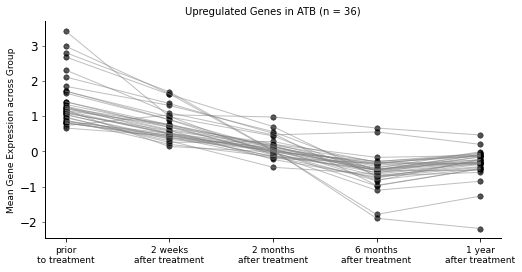

In [36]:
#plot the mean expression of each gene across each group
fig , ax = plt.subplots()

for gene_i in gene_set_columns:
    
    mean_gene_exp_measurements = []
    for group_i in group_ids:
        mean_gene_exp_measurements.append(mean_gene_exp_by_group[group_i][gene_i])
    
    ax.plot(range(1,len(group_ids)+1), mean_gene_exp_measurements , color = "0.5" , linewidth=1.0 , alpha = 0.5)
    ax.scatter(range(1,len(group_ids)+1), mean_gene_exp_measurements , color = "0.0" , alpha = 0.7 , s = 30)
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
ax.tick_params(labelcolor = 'k')
ax.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
ax.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

#ax.set_title('ATB v HC', fontsize = 12, color = 'k')
ax.set_ylabel('Mean Gene Expression across Group', fontsize = 9, color = 'k')
x_labels = group_tags
ax.set_xticks(range(1,len(group_ids)+1))
ax.set_xticklabels(x_labels, rotation='0', fontsize = 9)
ax.set_xlabel('')

ax.set_title(f'Upregulated Genes in ATB (n = {str(len(gene_set_columns))})', fontsize = 10)

fig = plt.gcf()
fig.set_size_inches(7.5, 4.0)
fig.tight_layout()

file_name = f'{figures_dir_path}Mean Gene Expression over Time upregulated genes.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

#### Top weighted nodes for genes in gene set that are *downregulated* in ATB  $(n = 11)$ 

In [37]:
gene_set = gene_sig_set_down

#subset exp matrix to include only genes in gene set
gene_set_columns = [gene_i for gene_i in gene_set if (gene_i in gene_exp_matrix_df.columns)] #make sure genes are in the columns of exp matrix
exp_matrix_gene_set_df = gene_exp_matrix_df.loc[: , gene_set_columns]

#dictionary that will hold a list of mean gene expressions across all individuals for each group
#keys:group, values:series of mean gene expression for genes in gene set
mean_gene_exp_by_group = {}
for group_i in group_ids:
    
    #subset gene exp dataframe to only individuals in this group
    exp_matrix_gene_set_group_df = exp_matrix_gene_set_df[gene_exp_info_df.group == group_i]
    
    #calculate the mean of each gene in gene set & store series for group
    mean_gene_exp_by_group[group_i] = exp_matrix_gene_set_group_df.mean()    

In [38]:
len(gene_set_columns)

11

Genes not found in Expression Matrix

In [39]:
print(list(set(gene_set) - set(gene_set_columns)))

[]


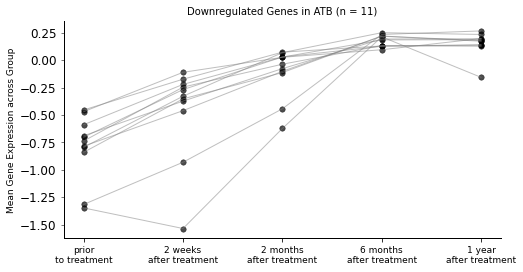

In [40]:
#plot the mean expression of each gene across each group
fig , ax = plt.subplots()

for gene_i in gene_set_columns:
    
    mean_gene_exp_measurements = []
    for group_i in group_ids:
        mean_gene_exp_measurements.append(mean_gene_exp_by_group[group_i][gene_i])
    
    ax.plot(range(1,len(group_ids)+1), mean_gene_exp_measurements , color = "0.5" , linewidth=1.0 , alpha = 0.5)
    ax.scatter(range(1,len(group_ids)+1), mean_gene_exp_measurements , color = "0.0" , alpha = 0.7 , s = 30)
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)
ax.tick_params(labelcolor = 'k')
ax.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
ax.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

#ax.set_title('ATB v HC', fontsize = 12, color = 'k')
ax.set_ylabel('Mean Gene Expression across Group', fontsize = 9, color = 'k')
x_labels = group_tags
ax.set_xticks(range(1,len(group_ids)+1))
ax.set_xticklabels(x_labels, rotation='0', fontsize = 9)
ax.set_xlabel('')

ax.set_title(f'Downregulated Genes in ATB (n = {str(len(gene_set_columns))})', fontsize = 10)

fig = plt.gcf()
fig.set_size_inches(7.5, 4.0)
fig.tight_layout()

file_name = f'{figures_dir_path}Mean Gene Expression over Time downregulated genes.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

### [2.2] *all* gene expression measurements per gene (in gene set) across different groups

### *Functions* to run Mann-Whitney U-test between different groups & draw barplot/swarmplots given a gene

In [41]:
def MU_test_between_groups_for_gene_expression(gene_id):
    
    '''Runs Mann-Witney U-test between all groups given a gene, returns a matrix with p-values'''
    
    #subset exp matrix to include only genes in gene set
    exp_matrix_gene_exp_group_df = gene_exp_matrix_df.loc[: , [gene_id]]
    MW_U_tests_DF = pd.DataFrame(index = group_ids , columns = group_ids) #DF to store p-values from Mann-Whitney U-tests

    #dictionary that will hold a list of gene expressions measurements across all individuals for each group
    #keys:group, values:list of gene expression for this gene
    gene_exp_measurements_by_group = {}
    for group_i in group_ids:

        #get gene exp for individuals in category i
        gene_exp_values_for_group_i = list(exp_matrix_gene_exp_group_df[gene_exp_info_df.group == group_i].loc[: , gene_id].values)

        for group_j in group_ids:

            #get gene exp for individuals in category j
            gene_exp_values_for_group_j = list(exp_matrix_gene_exp_group_df[gene_exp_info_df.group == group_j].loc[: , gene_id].values)

            #Mann Whitney U test for differences in gene exp between both group
            non_parametric_test_pval = scipy.stats.mannwhitneyu(gene_exp_values_for_group_i , gene_exp_values_for_group_j)[1]
            MW_U_tests_DF.loc[group_i , group_j] = non_parametric_test_pval
            
    return MW_U_tests_DF

In [42]:
def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input) # modified to take the height directly as input
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    #lx, ly = center[num1], height[num1] 
    #rx, ry = center[num2], height[num2]
    lx, ly = center[num1], height # modified to set height directly from input
    rx, ry = center[num2], height # modified to set height directly from input

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    #bary = [y, y+barh, y+barh, y]
    bary = [y+barh, y+barh, y+barh, y+barh] # modified to remove side bars
    #mid = ((lx+rx)/2, y+barh)
    mid = ((lx+rx)/2, y+0.92*barh) # modified to move text closer to bar

    #plt.plot(barx, bary, c='black') 
    plt.plot(barx, bary, c='black', linewidth = 0.7) # modified to decrease linewidth

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)

In [43]:
def create_gene_exp_boxplot_swarmplot_for_all_groups(gene_id):
    
    '''
    Draws barplot & swarmplot for all gene expression measurements for all individuals in dataset
    (broken down by group) given a gene.
    '''

    sns.set_theme(style="whitegrid")

    group_indices = group_ids

    #subset exp matrix to include only genes in gene set
    exp_matrix_gene_exp_group_df = gene_exp_matrix_df.loc[: , [gene_id]]

    #create a list that stores the gene expression values across all individuals for a specific gene broken down by group
    gene_exp_measurements_by_group = []
    heights = [] #height corresponds to max exp value per group
    for group_i in group_indices:

        #subset gene exp dataframe to only individuals in this group & store values as a list for group
        gene_exp_measurements_by_group.append(list(exp_matrix_gene_exp_group_df[gene_exp_info_df.group == group_i].loc[: , gene_id].values))
        heights.append(np.max(list(exp_matrix_gene_exp_group_df[gene_exp_info_df.group == group_i].loc[: , gene_id].values)))

    #draw boxplot & swarmplot
    ax = sns.swarmplot(data=gene_exp_measurements_by_group, color='0', size = 2.25)
    ax = sns.boxplot(data=gene_exp_measurements_by_group, color='xkcd:yellow', whis=np.inf, linewidth = 1.0)

    #annotate significance between groups using Mann-Witney U-test results
    MU_test_gene_i = MU_test_between_groups_for_gene_expression(gene_id)
    MU_test_gene_i_np_vs_others = MU_test_gene_i.loc[group_ids[0] , group_ids[1:]]

    #plot significance bars between
    space_btwn_sig_lines = np.max( [0.2, ((np.max(heights) - np.min(heights)) * 0.08) ]) #vertical space between bars indicated p-val
    group_i_sig_annot_height = np.max(heights) + (space_btwn_sig_lines / 10.0)

    for other_group_i, MU_test_pval in zip(range(1,len(group_indices)), MU_test_gene_i_np_vs_others.values):
        barplot_annotate_brackets(0, other_group_i, MU_test_pval, range(0,len(group_indices)), height=group_i_sig_annot_height, dh = 0, maxasterix=3, fs = 9)
        group_i_sig_annot_height += space_btwn_sig_lines

    #x-axis
    ax.set_xlim(-0.5 , len(group_ids)-0.5)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(False)
    ax.tick_params(labelcolor = 'k')
    ax.tick_params(axis='y', which='major', labelsize=8 , labelcolor = 'k')
    ax.tick_params(axis='x', which='major', labelsize=8 , labelcolor = 'k')

    ax.set_ylabel('Gene Expression', fontsize = 8, color = 'k')

    ax.set_xticks(range(0,len(group_indices)))
    ax.set_xticklabels(group_tags, rotation='0', fontsize = 8)
    ax.set_xlabel('')

    ax.set_title(gene_id, fontsize = 9, fontweight = 'bold')

    fig = plt.gcf()
    fig.set_size_inches(7.0, 5.0)
    fig.tight_layout()

    file_name = f'{figures_dir_path}/{gene_id} Gene Expression over Time.pdf'
    plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

    plt.show()
    print('-----------------------------------------------------------------------------------------------------------')

### *upregulated* genes in gene signature

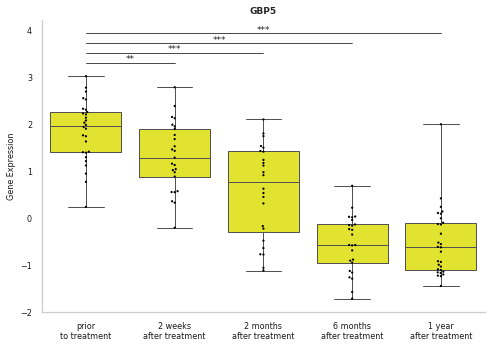

-----------------------------------------------------------------------------------------------------------


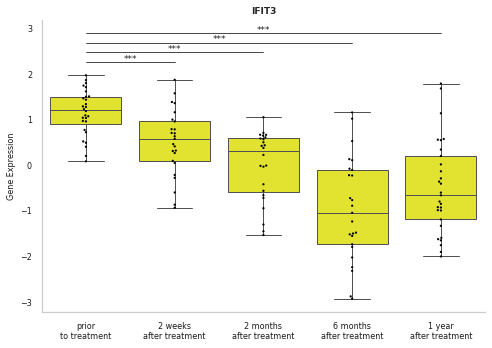

-----------------------------------------------------------------------------------------------------------


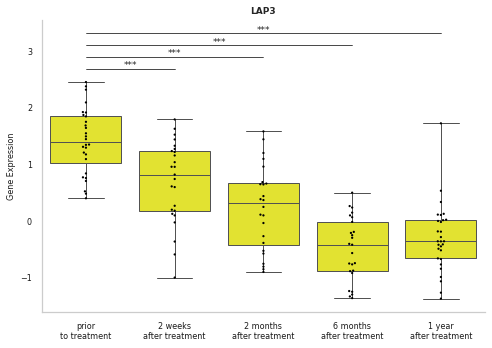

-----------------------------------------------------------------------------------------------------------


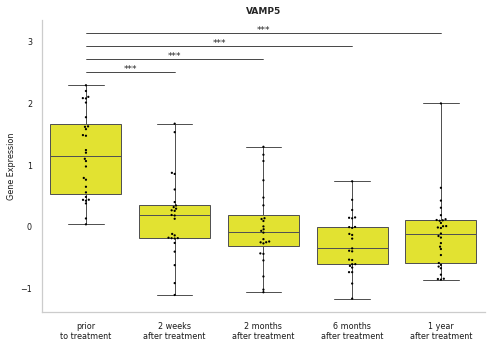

-----------------------------------------------------------------------------------------------------------


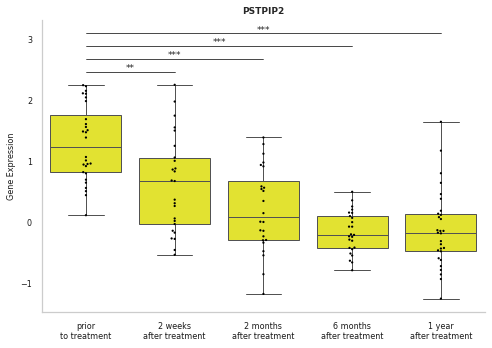

-----------------------------------------------------------------------------------------------------------


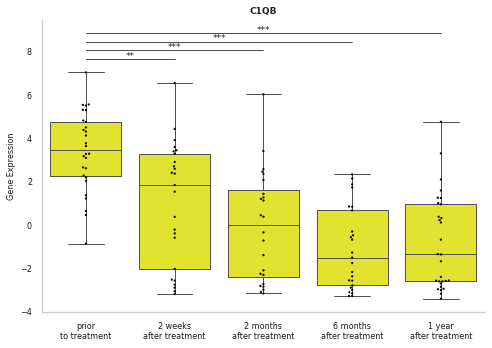

-----------------------------------------------------------------------------------------------------------


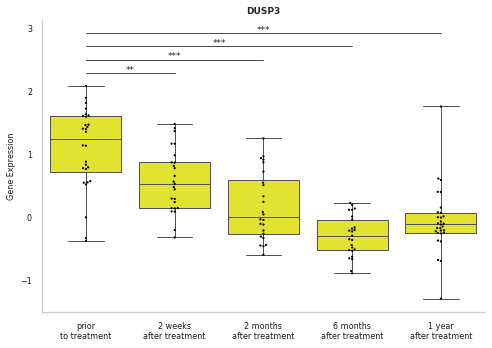

-----------------------------------------------------------------------------------------------------------


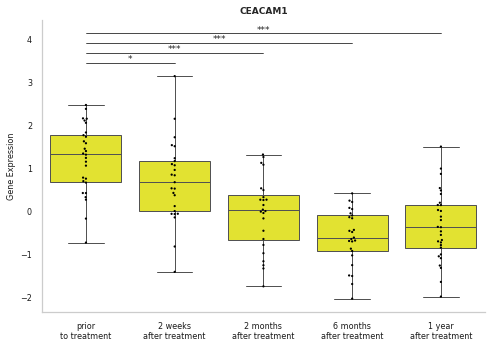

-----------------------------------------------------------------------------------------------------------


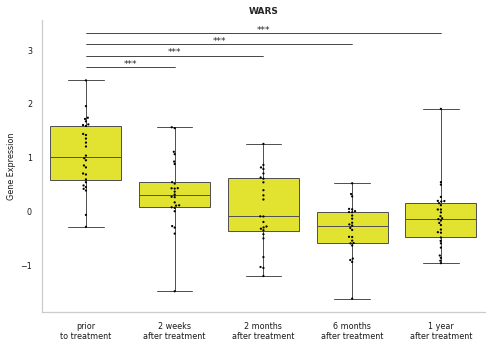

-----------------------------------------------------------------------------------------------------------


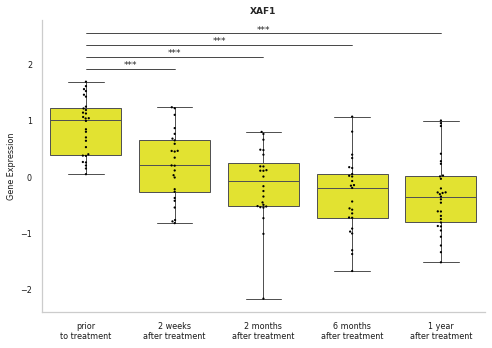

-----------------------------------------------------------------------------------------------------------


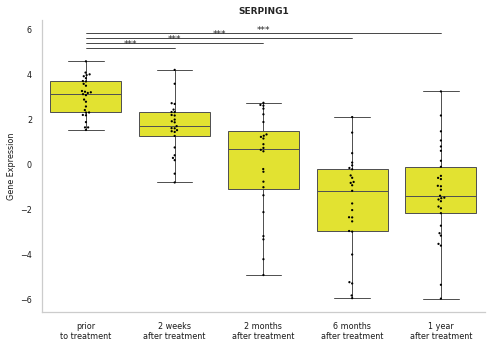

-----------------------------------------------------------------------------------------------------------


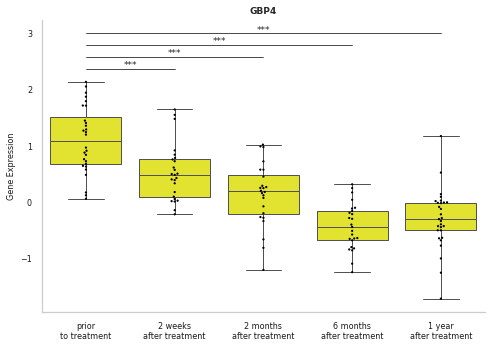

-----------------------------------------------------------------------------------------------------------


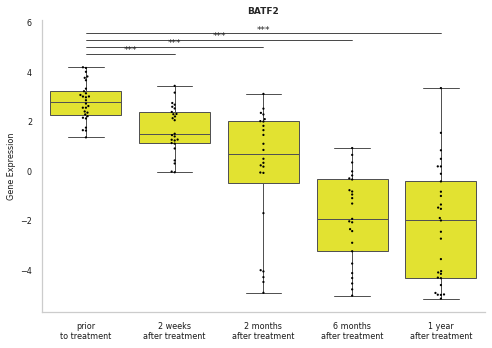

-----------------------------------------------------------------------------------------------------------


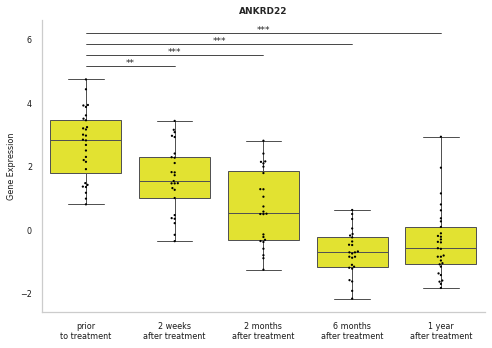

-----------------------------------------------------------------------------------------------------------


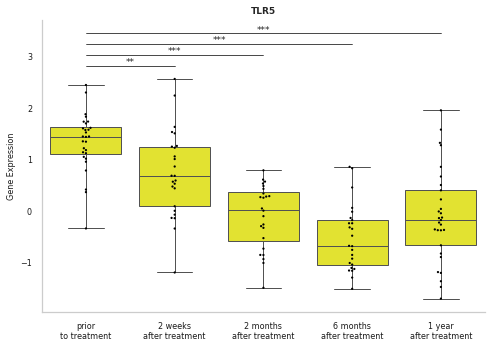

-----------------------------------------------------------------------------------------------------------


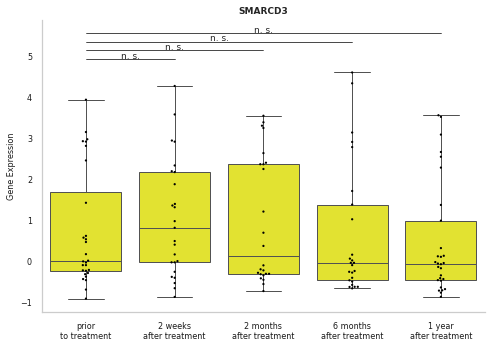

-----------------------------------------------------------------------------------------------------------


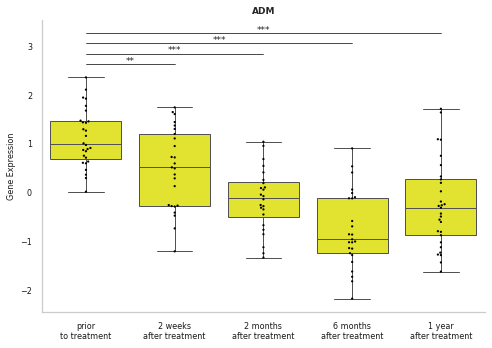

-----------------------------------------------------------------------------------------------------------


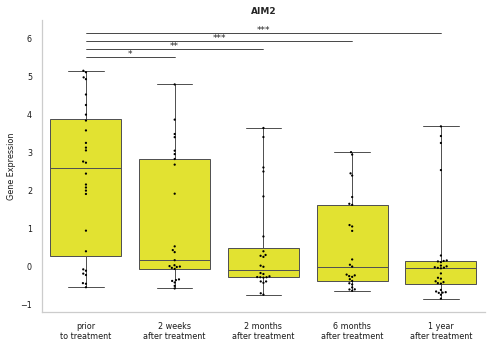

-----------------------------------------------------------------------------------------------------------


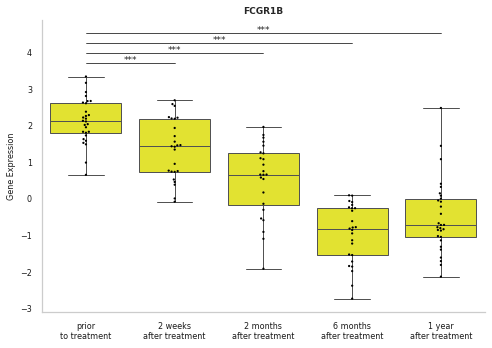

-----------------------------------------------------------------------------------------------------------


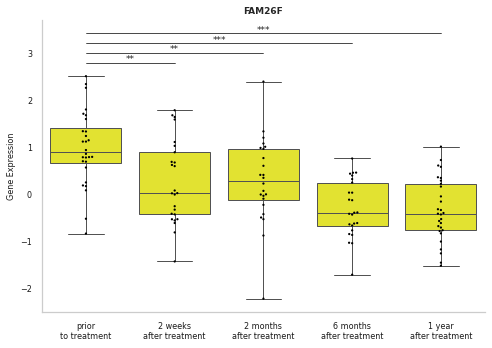

-----------------------------------------------------------------------------------------------------------


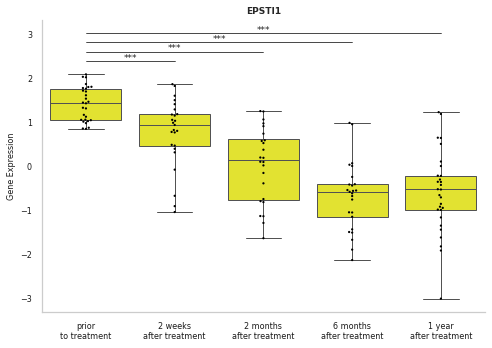

-----------------------------------------------------------------------------------------------------------


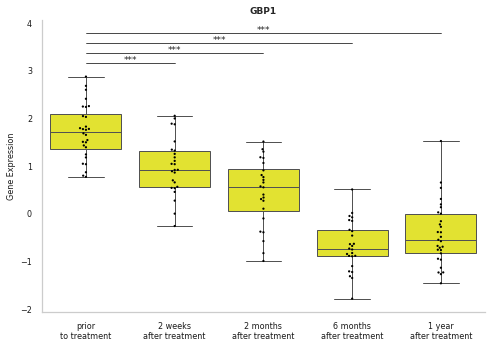

-----------------------------------------------------------------------------------------------------------


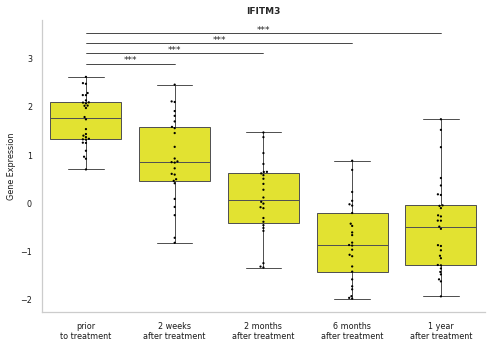

-----------------------------------------------------------------------------------------------------------


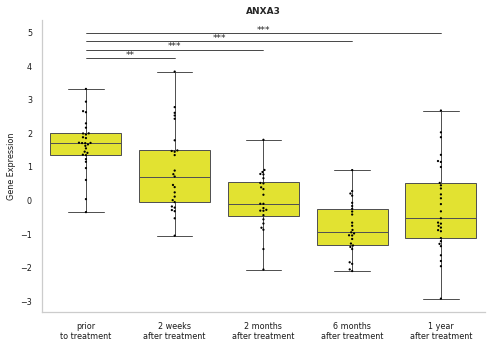

-----------------------------------------------------------------------------------------------------------


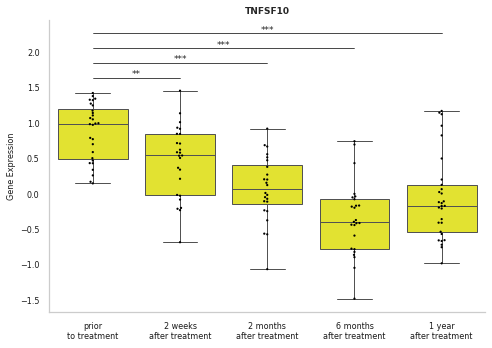

-----------------------------------------------------------------------------------------------------------


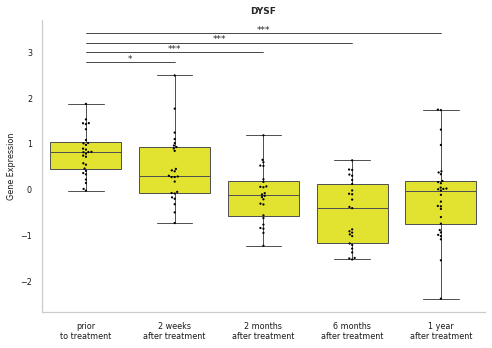

-----------------------------------------------------------------------------------------------------------


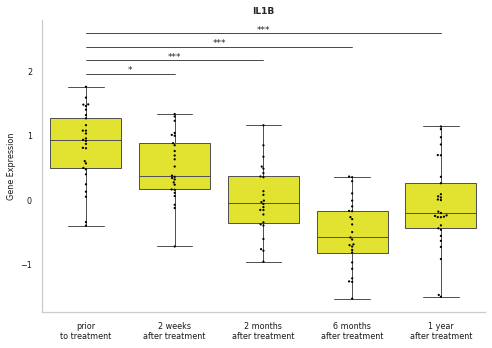

-----------------------------------------------------------------------------------------------------------


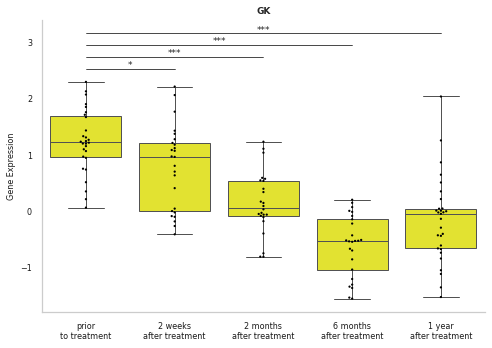

-----------------------------------------------------------------------------------------------------------


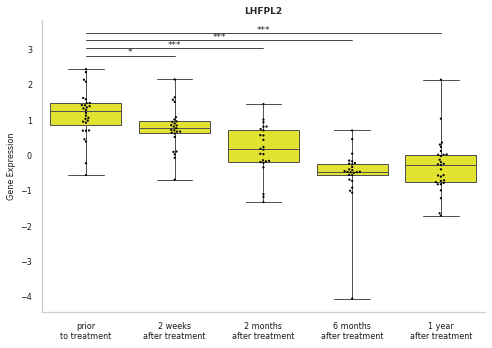

-----------------------------------------------------------------------------------------------------------


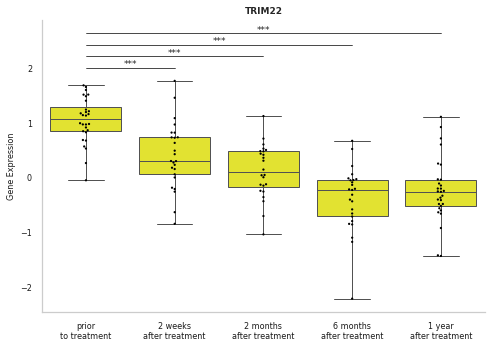

-----------------------------------------------------------------------------------------------------------


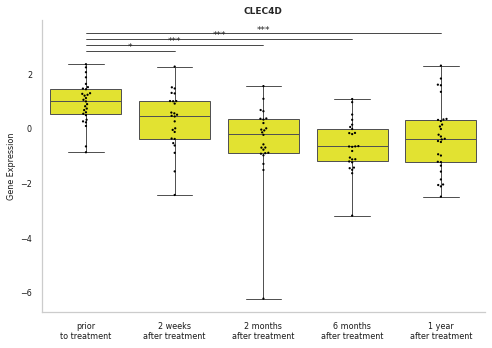

-----------------------------------------------------------------------------------------------------------


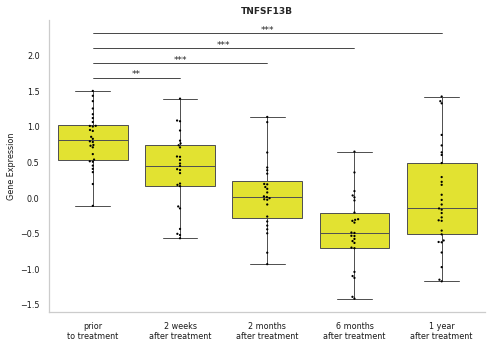

-----------------------------------------------------------------------------------------------------------


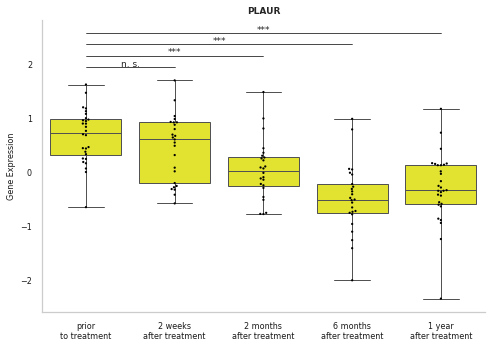

-----------------------------------------------------------------------------------------------------------


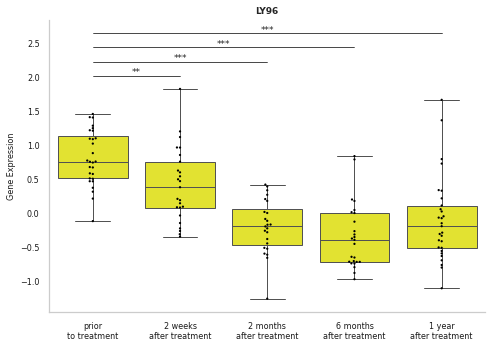

-----------------------------------------------------------------------------------------------------------


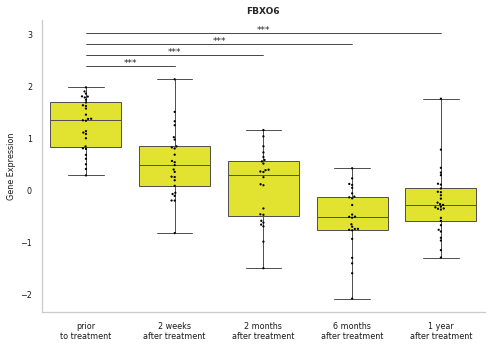

-----------------------------------------------------------------------------------------------------------


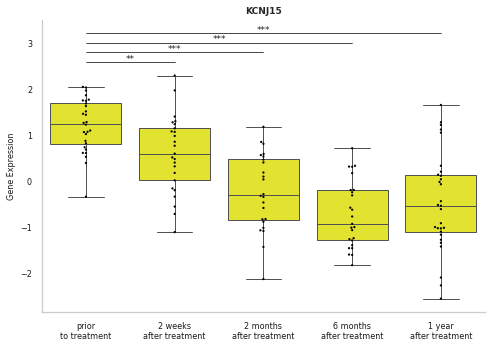

-----------------------------------------------------------------------------------------------------------


In [44]:
for gene_id in gene_sig_set_up:
    
    if gene_id in gene_exp_matrix_df.columns:
        
        create_gene_exp_boxplot_swarmplot_for_all_groups(gene_id)

### *downregulated* genes in gene signature

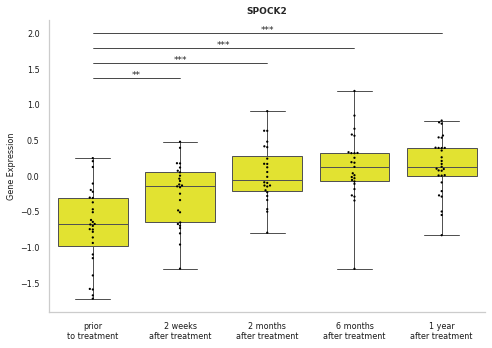

-----------------------------------------------------------------------------------------------------------


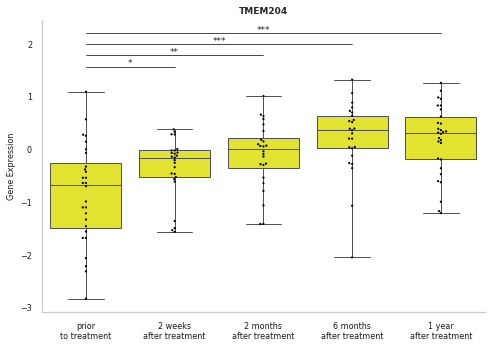

-----------------------------------------------------------------------------------------------------------


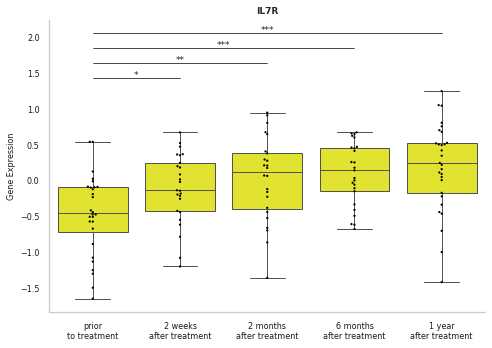

-----------------------------------------------------------------------------------------------------------


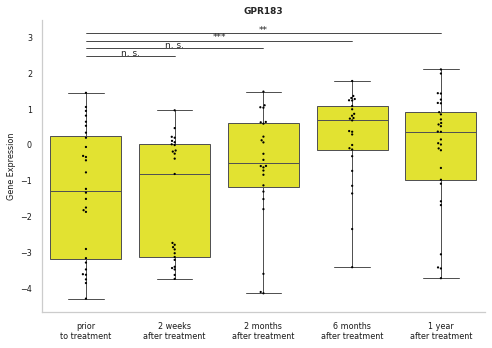

-----------------------------------------------------------------------------------------------------------


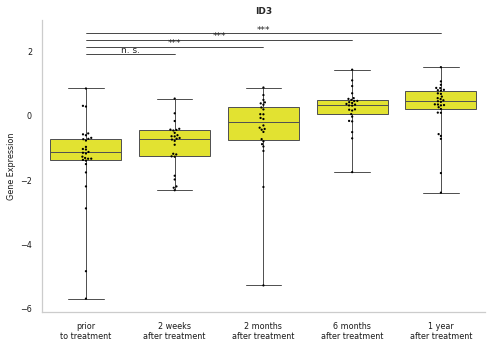

-----------------------------------------------------------------------------------------------------------


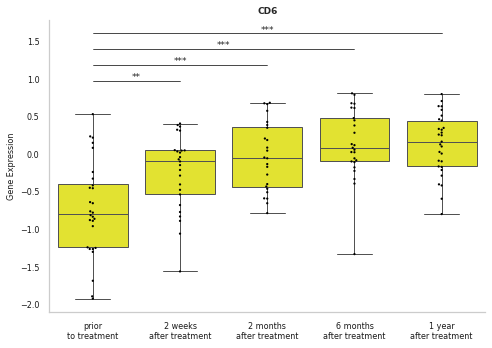

-----------------------------------------------------------------------------------------------------------


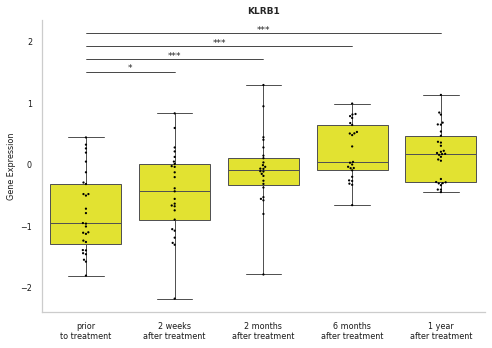

-----------------------------------------------------------------------------------------------------------


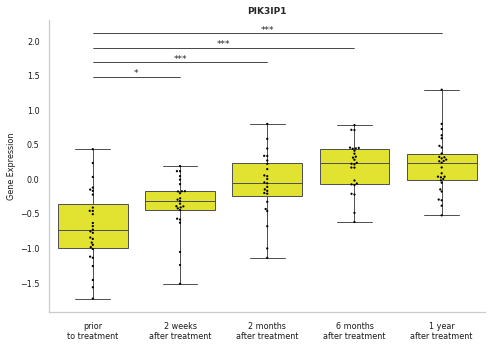

-----------------------------------------------------------------------------------------------------------


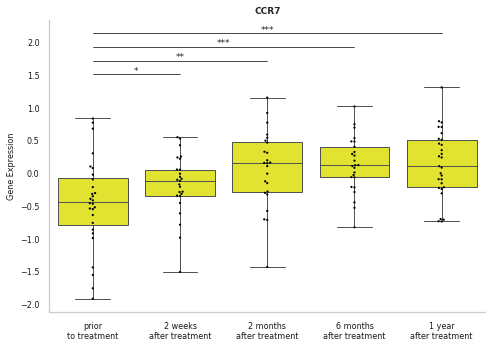

-----------------------------------------------------------------------------------------------------------


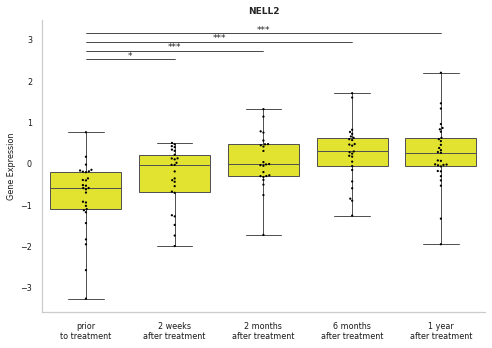

-----------------------------------------------------------------------------------------------------------


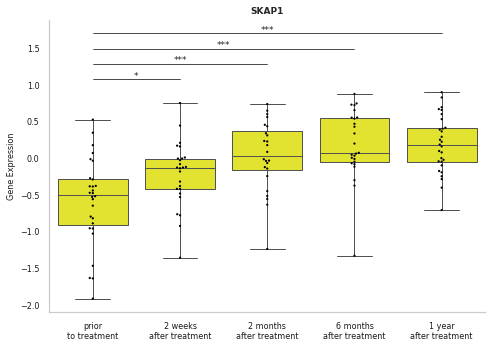

-----------------------------------------------------------------------------------------------------------


In [45]:
for gene_id in gene_sig_set_down:
    
    if gene_id in gene_exp_matrix_df.columns:
        
        create_gene_exp_boxplot_swarmplot_for_all_groups(gene_id)